## Question1
1. Company A is developing a product that provides funds to companies based on future sales (future receivables). A team of data scientists is creating a machine learning model to predict future sales based on historical sales data from several companies.

    You are the manager of Company A's data scientist team, and a member data scientist says, "The back-test accuracy was very high  (RMSE was very low), but for some reason the accuracy after production (actual service) was worse than the back-test, and the return on investment (recovered funds/provided funds) was also worse than expected It was bad," they said. In this case, what are the possible problems and what measures should be taken for each of them? If you can think of more than one possible problem, please list them all. However, assume that the program itself does not contain any bugs.

### Answer
#### Overfitting of the model to the trainig data. There are several reasons.
    1. Overfitting due to large dimension: If the dimensions (ie predictor / features) are large, then the model would be training and trying to fit every pattern for rsme error to reduce. This overfitting will lead to low performace on acutal data.
       1. Solution: Try to select less correlated features by using domain expertise first.And then slowing adding new features one by one and testing the model one by one.
            > If domain expertise is not availabe, then use of automated feature selection algorithms like RFE:Recursive feature elimination,recursive feature elimination with cross validation etc can be used and tested for improved performances. 
            > RandomForestregression also provides a method to access the feature importance by training & calculating the weighted sum of how much feature is used in each node to reduce its impurity/entropy errors. It can be accessed by .feature_importance_ method. 
            > Also, techniques like random subspaces training will tend to lower vairance due to high dimentionality of features.Similarly, random patches can also be tried.
    2. Non-linear model on linear dataset: If the dataset itself has linear relationship, then highly non-linear models will tend to overfit to give the best cost function output for training.  
       1. Solution: Make a simple model and then iteratively improvize it.
          > simple models can perform better as their weights updates are biased due to linearity.

    3. Lack of sufficient training observations: If training observation is not sufficient for the model to really fine tune, then overfitting is generally the case. 
        1. Solution: Try to use cross-validation like K fold crossvalidation on the training  dataset to reduce overfitting. 
        2. Getting more data: By getting more data, the model will be exposed to more trainig data, and thus the variance will decrease due to adjusting the weights.  
    Finally, try in all of the above cases: 
        3. Regularization: Use of Rigid/ Lasso regularization will be useful to constraints the weights while training the models.For decision trees: controlling hyper_parameters like max_leaf_nodes, reducing max_depth,pruning unnecessary nodes (from decision trees) etc will help in regularization. 
        4. Ensembling models so that the overfitting of only one model can be reduced by the weighted effects of other models. 
1. 


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import seaborn as sns
from scipy.stats import norm

### Question2: GOAL of this ML model. 
#### Predicting the future revenue of a company. Its a regression problem. 

In [2]:
train_df = pd.read_csv('train.csv', low_memory=True)
test_df = pd.read_csv('test.csv', low_memory=True)

#### Exploratory Data Analysis ( EDA )

In [3]:
train_df.shape
test_df.shape

(688, 7)

In [4]:
# Taking a quick look at the data. 
train_df.head()

,company_id,rating by external agency,moving_avg_churn_rate,users,current_revenue,sector,future_revenue
0,1888,C,0.023493,289.0,7609,b,4551
1,2642,A,0.003929,198.0,8377,c,12602
2,2100,A,0.023319,316.0,8876,c,10537
3,1841,B,0.009618,354.0,7894,b,6364
4,418,C,0.048059,279.0,7778,d,4151


In [5]:
# Checking for null values sum for each column. 
train_df.isnull().sum()
test_df.isnull().sum()
# As there are no null values, IMPUTATION is not required.

company_id                   0
rating by external agency    0
moving_avg_churn_rate        0
users                        0
current_revenue              0
sector                       0
future_revenue               0
dtype: int64

In [6]:
# Checking types of data 
train_df.dtypes


company_id                     int64
rating by external agency     object
moving_avg_churn_rate        float64
users                        float64
current_revenue                int64
sector                        object
future_revenue                 int64
dtype: object

In [7]:
train_df.describe()

,company_id,moving_avg_churn_rate,users,current_revenue,future_revenue
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1339.762500,0.054981,329.233000,8847.762000,6693.045000
std,780.265624,0.028836,148.270978,2914.148306,2936.817947
min,1.000000,0.000856,16.000000,1000.000000,-1251.000000
25%,657.750000,0.029482,207.000000,6688.000000,4386.250000
50%,1333.000000,0.056631,331.000000,8806.000000,6748.000000
75%,2025.250000,0.078987,459.000000,11055.000000,8992.250000
max,2687.000000,0.108575,618.000000,16495.000000,13870.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   company_id                 2000 non-null   int64  
 1   rating by external agency  2000 non-null   object 
 2   moving_avg_churn_rate      2000 non-null   float64
 3   users                      2000 non-null   float64
 4   current_revenue            2000 non-null   int64  
 5   sector                     2000 non-null   object 
 6   future_revenue             2000 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 109.5+ KB


In [9]:
# Checking sample of data
train_df.head()

,company_id,rating by external agency,moving_avg_churn_rate,users,current_revenue,sector,future_revenue
0,1888,C,0.023493,289.0,7609,b,4551
1,2642,A,0.003929,198.0,8377,c,12602
2,2100,A,0.023319,316.0,8876,c,10537
3,1841,B,0.009618,354.0,7894,b,6364
4,418,C,0.048059,279.0,7778,d,4151


##### Creating a new feature: revenue_per_user = current_revenue / users

In [10]:
# Creating anew feature: revenue_per_user = current_revenue / users
train_df['revenue_per_user'] = train_df['current_revenue'] / train_df['users']
# Creating the same for test
test_df['revenue_per_user'] = test_df['current_revenue'] / test_df['users']

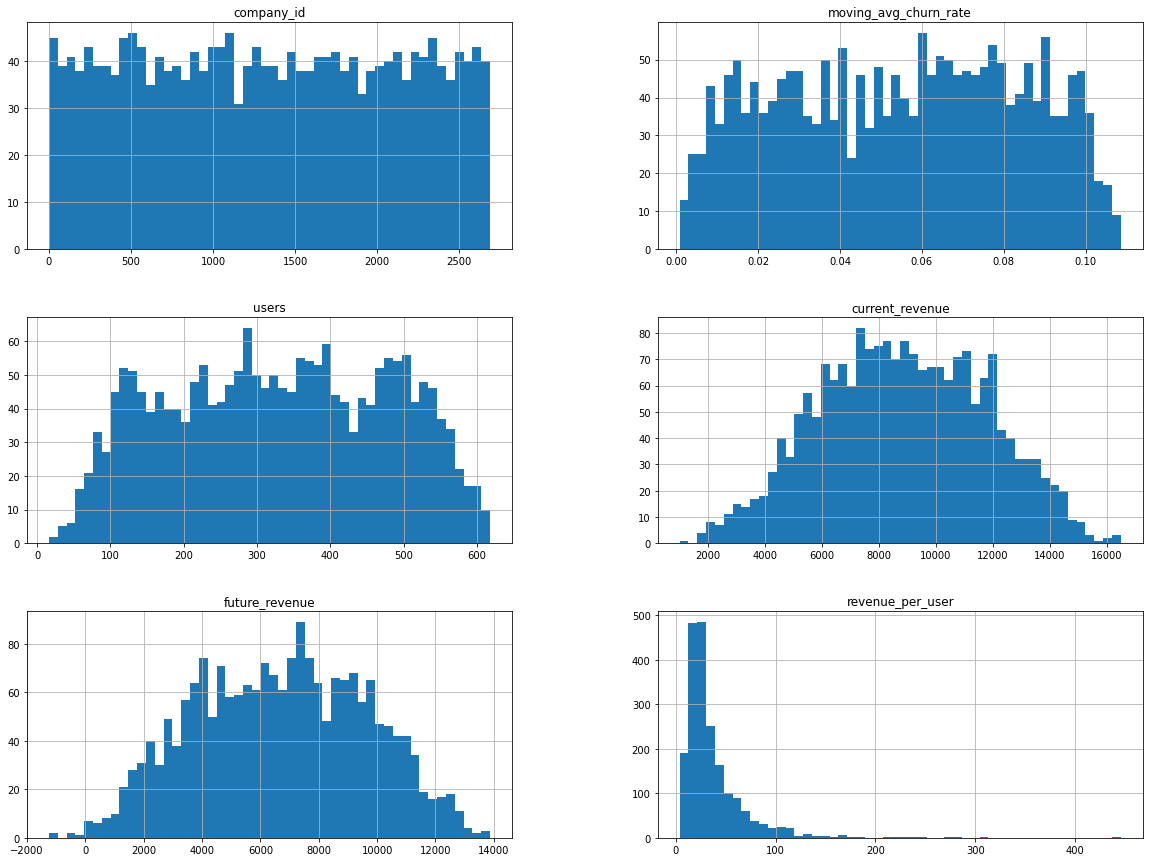

In [11]:
# EDA for train_df, we will not use test_df at all. 
# Creating a copy just for data exploration 
explore_df = train_df.copy()
# Lets look at the distribution of the data.
%matplotlib inline
import matplotlib.pyplot as plt
explore_df.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

future_revenue           1.000000
current_revenue          0.261298
revenue_per_user         0.070328
users                    0.027416
company_id              -0.022319
moving_avg_churn_rate   -0.074477
Name: future_revenue, dtype: float64
current_revenue          1.000000
moving_avg_churn_rate    0.491509
revenue_per_user         0.321356
future_revenue           0.261298
users                    0.060794
company_id               0.009365
Name: current_revenue, dtype: float64
Scatter plot


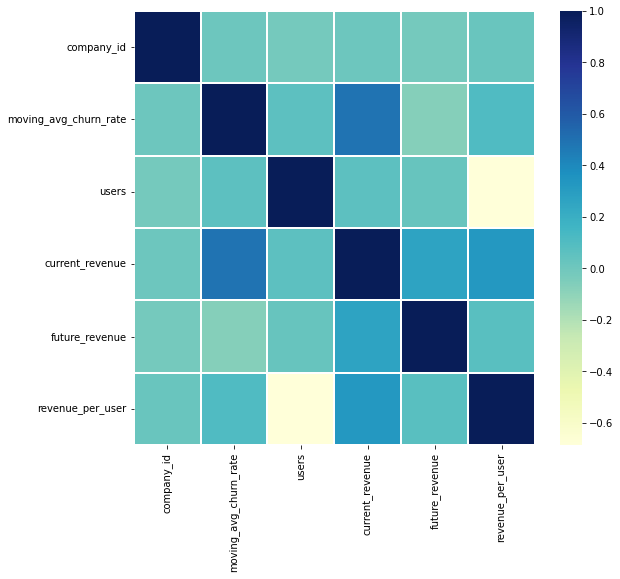

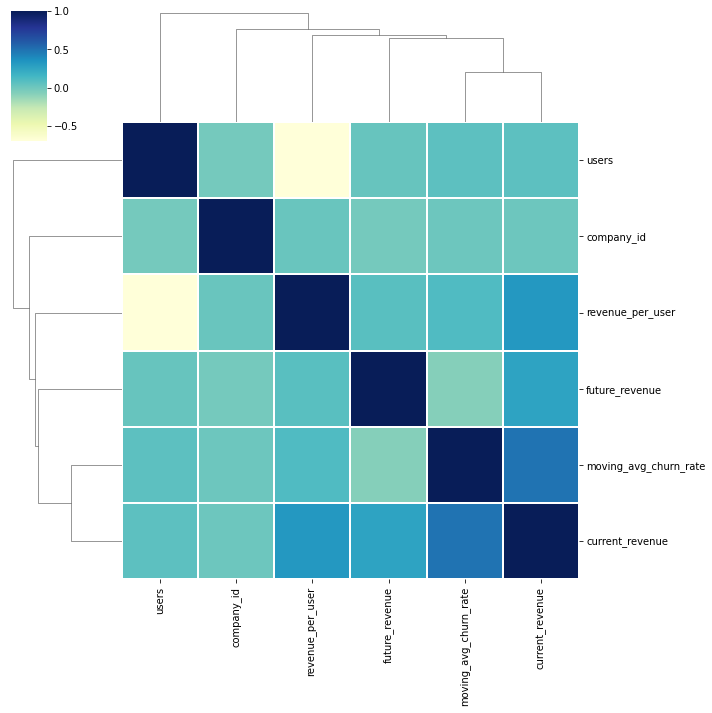

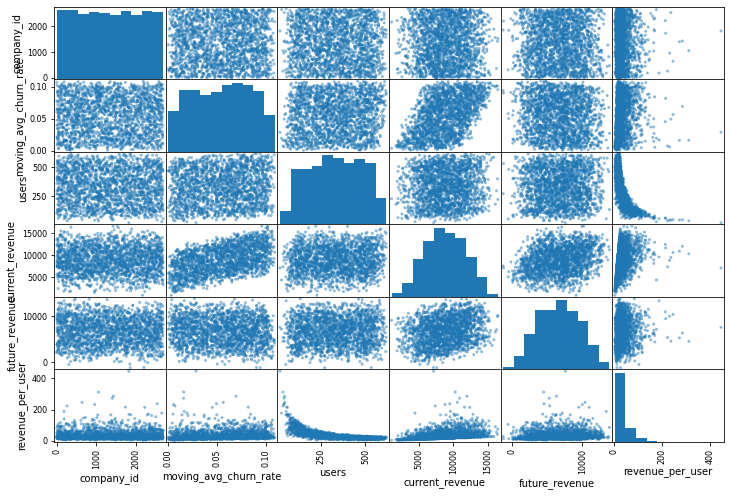

In [12]:
# Discusison 
# Current revenue and future revenue both follow gaussian distribution. 
# Checking correlation between features to gain more insight. 
corel = explore_df.corr()


print(corel["future_revenue"].sort_values(ascending=False))
print(corel["current_revenue"].sort_values(ascending=False))


f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corel, ax = ax, cmap ="YlGnBu", linewidths = 0.1)


cg = sns.clustermap(corel, cmap ="YlGnBu", linewidths = 0.1)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)


# print(corel)
# corel matrix plot 

##Plotting Scatter Plot 
from pandas.plotting import scatter_matrix
cols = list(explore_df.columns)
scatter_matrix(explore_df[cols], figsize=(12, 8))
print('Scatter plot')





#### Discusison:

**This is a very interesting obersvation.**
1. When we look at the variables that are correlted to future revenue, then we 
see that mv_avg_churn_rate plays a singficant role for negatively correlation
and current revenue for positively correlation.
2. But when looking at current_revenue based correlation, moving avg churn rate
 is positively correlated. 
 
By: defintion high churn rate means less growth, so less future revenue. So, it is a very good predictor! 

**By looking at total heat map and scatter plot, it can be 
confirmed that current_revenue and mv_avg_churn_rate are highly correlated.**

**Also COMPANY ID IS NOT AT ALL CORRELATED. AS ITS JUST AN ID. 
This should be removed as its not needed.**

**Furthermore, the derivied feature: revenue per user is much more 
correlatd than number of users.**

#### More understanding of churn rate : 
The churn rate measures a company's loss in subscribers for a given period of time.



In [13]:
### Feature Engineering & Encoding

In [14]:
# Standardising the numerical cols. using standard scaler pipeline. 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Not including company_id as its not needed 
numerical_columns = [
#    'company_id', 
    # 'rating by external agency', 
    'moving_avg_churn_rate',
    'users', 
    'current_revenue',
    'revenue_per_user', 
#     'sector'
]
# Categorical Columsn 
categorical_columns = ['rating by external agency', 'sector']



In [15]:
# # Method1 for feature engineering
# # Divide the test and train df into num and cat df.
# # Preprocess them and concatinate them. 
# # As with all the transformations, it is important to 
# # fit the scalers to the training data only, not to the 
# # full dataset (including the test set).
# def preprocess_df(type,df,algo,col_lst,test_df):
#     if type=='num':
#         process_df = df[col_lst]
       
#         if algo=='standard_scalar':
#             s=StandardScaler()
#             s.fit(process_df)
#             train_process_df = pd.DataFrame(s.transform(process_df),\
#                 index=process_df.index,columns=process_df.columns)
#             test_process_df = pd.DataFrame(s.transform(test_df[col_lst]),\
#                 index=test_df[col_lst].index,columns=test_df[col_lst].columns)
#             return train_process_df,test_process_df
#         if algo == 'min_max_scalar':
#             s=MinMaxScaler()
#             s.fit(process_df)
#             train_process_df = pd.DataFrame(s.transform(process_df),\
#                 index=process_df.index,columns=process_df.columns)
#             test_process_df = pd.DataFrame(s.transform(test_df[col_lst]),\
#                 index=test_df[col_lst].index,columns=test_df[col_lst].columns)
#             return train_process_df,test_process_df
    
#     if type=='cat':
#         process_df = df[col_lst]
#         if algo=='one_hot_encoder':
#             o = OneHotEncoder(handle_unknown='ignore',sparse=False)
#             o.fit(process_df)
            
#             train_process_df =pd.DataFrame(o.transform(process_df),columns=o.get_feature_names_out())
#             test_process_df =pd.DataFrame(o.transform(test_df[col_lst]),columns=o.get_feature_names_out())
            
#             return train_process_df,test_process_df

#         if algo=='dummy_categorical':
            
#             train_process_df = pd.get_dummies(df[col_lst])
#             test_process_df = pd.get_dummies(test_df[col_lst])
#             return train_process_df,test_process_df
#     pass


# train_num_df,test_num_df = preprocess_df('num',train_df,'min_max_scalar',numerical_columns,test_df)
# ## If no num processing then: 
# # train_num_df = train_df[numerical_columns]
# # test_num_df = test_df[numerical_columns] 

# train_cat_df,test_cat_df = preprocess_df('cat',train_df,'one_hot_encoder',categorical_columns,test_df)
# display(train_num_df)
# display(test_num_df)
# display(train_cat_df)
# display(test_cat_df)

# # Concatinating two dataframe 
# train_process_df = pd.concat([train_num_df,train_cat_df],axis=1)
# display(train_process_df)
# test_process_df = pd.concat([test_num_df,test_cat_df],axis=1)
# display(test_process_df)

In [16]:
## METHOD 2 for feature engineering: PIPELINE TECHNIQUE
##---------------------------------------------------------------------------------------------------------------------
## Alternate Pipelining using ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline(
    [ 
    # ('imputer', SimpleImputer(strategy="mean")), 
    # ('std_scaler', StandardScaler()),
    ('min_max_scaler', MinMaxScaler())
])
encoding_pipleline = ColumnTransformer([
    ("num",num_pipeline,numerical_columns),
    ("cat",OneHotEncoder(handle_unknown='ignore',sparse=False),categorical_columns),
])
encoding_pipleline.fit(train_df)
train_process_df = pd.DataFrame(encoding_pipleline.transform(train_df),columns=encoding_pipleline.get_feature_names_out())
display(train_process_df)
test_process_df = pd.DataFrame(encoding_pipleline.transform(test_df),columns=encoding_pipleline.get_feature_names_out())
display(test_process_df)
# Geting the total features names from encoding pipeline
# print(encoding_pipleline.get_feature_names_out())



# preprocessor.fit(train_df)
# x=preprocessor.transform(train_df)
# train_df_final=pd.DataFrame(preprocessor.transform(train_df),columns=train_df.columns)
# train_df_final.head()
# scalar = StandardScaler()
# num_df = train_df[numerical_columns]
# num_df=pd.DataFrame(scalar.fit_transform(num_df.values),index=num_df.index,columns=num_df.columns)
# num_df.head()

,num__moving_avg_churn_rate,num__users,num__current_revenue,num__revenue_per_user,cat__rating by external agency_A,cat__rating by external agency_B,cat__rating by external agency_C,cat__rating by external agency_D,cat__sector_a,cat__sector_b,cat__sector_c,cat__sector_d
0,0.210147,0.453488,0.426525,0.050436,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.028527,0.302326,0.476089,0.086629,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.208539,0.498339,0.508293,0.054422,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.081348,0.561462,0.444918,0.041309,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.438206,0.436877,0.437431,0.053945,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.325951,0.817276,0.165086,0.006665,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1996,0.565913,0.280731,0.404647,0.079810,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1997,0.284513,0.212625,0.152436,0.043683,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1998,0.049648,0.752492,0.260342,0.015113,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


,num__moving_avg_churn_rate,num__users,num__current_revenue,num__revenue_per_user,cat__rating by external agency_A,cat__rating by external agency_B,cat__rating by external agency_C,cat__rating by external agency_D,cat__sector_a,cat__sector_b,cat__sector_c,cat__sector_d
0,0.483931,0.960133,0.404711,0.018527,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.058713,0.875415,0.475831,0.025727,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.260226,0.398671,0.546886,0.074624,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.632927,0.388704,0.369861,0.051784,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.648996,0.126246,0.354114,0.150508,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
683,0.672547,0.609635,0.348112,0.028614,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
684,0.289128,0.679402,0.703711,0.054243,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
685,0.740816,0.167774,0.471120,0.151481,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
686,0.821913,0.687708,0.643950,0.048627,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [17]:
# # TODO: Piplelining technique. 
# from sklearn.pipeline import make_pipeline
# categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
# numerical_preprocessor = StandardScaler()
# preprocessor = ColumnTransformer([
#     ('one-hot-encoder', categorical_preprocessor, categorical_columns),
#     ('standard_scaler', numerical_preprocessor, numerical_columns)])
# model = make_pipeline(preprocessor,  RandomForestRegressor(
#     random_state=0))
# from sklearn import set_config
# set_config(display='diagram')
# model
# _ = model.fit(train_df, target_train)

In [18]:
# # Getting columns along with catergorical columns. 
# new_features = list(train_cat_df.columns)
# # Removing the compnay ID is a good idea because it is not a good predictor.
# new_features.remove('company_id')
# # new_features = list(train_cat_df.columns)
# print(new_features)
# train_df = train_cat_df.copy()
# test_df = test_cat_df.copy()

In [19]:
target = ['future_revenue']
target_train_df = train_df[target]
target_test_df = test_df[target]
display(type(target_train_df))
display(target_test_df)

pandas.core.frame.DataFrame

,future_revenue
0,3296
1,10763
2,2884
3,4386
4,6059
...,...
683,3667
684,5432
685,8139
686,9101


In [20]:
x_train, y_train = train_process_df, target_train_df
x_test, y_test = test_process_df, target_test_df

# x_train, y_train = train_df[features], train_df[target]
# x_test, y_test = test_df[features], test_df[target]

In [21]:
# type(y_test)
# type(x_test)

In [22]:
x_train.shape
y_train.shape

(2000, 1)

In [23]:
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print('rmse',rmse)    
    return rmse
def rmse_stats(score):
    print("Scores:", score)
    print("Mean:", score.mean())
    print("Standard deviation:", score.std())
model = RandomForestRegressor(random_state=0)
model.fit(x_train, y_train)

# rmse(y_test, y_predict)

/home/uncomment/miniconda3/envs/learn_datascience/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RandomForestRegressor(random_state=0)

In [24]:
## AFTER TRAINNG THE MODEL ON THE TRAIN DATASET, WE USE THE SAME DATASET TO 
## CHECK THE UNDERFITTING/ OVERFITTING NATURE OF MODEL. 
y_train_predict = model.predict(x_train)
score=rmse(y_train, y_train_predict)
# rmse_stats(score)

rmse 1032.0869397693684


In [25]:
## K -FOLD CROSSVALIDATION FOR MODEL EVALUATION.
from sklearn.model_selection import cross_val_score
# using 3 fold as the dataset is only 2000 observations.
neg_mse_score = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error',cv=3)
rmse_score = np.sqrt(np.abs(neg_mse_score))
rmse_stats(rmse_score)

"""
With standard deviation of +- 25, we can say that the model is either precise / or 
maybe overfitting. ie. variance may be high, but not bias. 
Also, score on the training set : around 1000 is much lower than validation set.~2700. 
That means, the model may be overfitting the training set. Or the dataset itself is significantly less.

"""

/home/uncomment/miniconda3/envs/learn_datascience/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/uncomment/miniconda3/envs/learn_datascience/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/uncomment/miniconda3/envs/learn_datascience/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Scores: [2741.94816695 2782.52848536 2800.3156921 ]
Mean: 2774.930781471872
Standard deviation: 24.426567862232083


'\nWith standard deviation of +- 25, we can say that the model is either precise / or \nmaybe overfitting. ie. variance may be high, but not bias. \nAlso, score on the training set : around 1000 is much lower than validation set.~2700. \nThat means, the model may be overfitting the training set. Or the dataset itself is significantly less.\n\n'

#### HYPERPARAMETER FINE TUNING OF THE MODEL USING GRID SEARCH OPTIMIZATION. 

In [26]:
%%capture
## FINE TUNING OF THE MODEL USING GRID SEARCH OPTIMIZATION. 
from sklearn.model_selection import GridSearchCV

## Intital param_grid for RandomForestRegressor
# param_grid = [ {'n_estimators': [30,40,50,60], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [2, 10], 'max_features': [2, 3, 4]},
# ] 

## second param grid. 
# param_grid = [ {'n_estimators': [30,40,50,60], 'max_features': [2, 4, 6, 8],'max_depth':[4,6,8],'max_leaf_nodes':[4,8,16]}] 

## third param grid. 
param_grid = [ {'n_estimators': [30,40,50,60], 'max_features': [8,10,12],'max_depth':[8,10,12],'max_leaf_nodes':[8,16,20]}] 
'''
I could use random search to find the best parameters but that will be computaation intensive. 
I am adding MAX_DEPTH & MAX_LEAF_NODES to the param_grid BECAUSE THEY WILL DECREASE OVERFITTING 
IN THE TRAINNG DATASET.  This will ensure that the model performs good in the test set as well. 

'''
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(x_train, y_train)

## DISCUSSION 
- **It was observed that after we added new hyperparameter tuning**
- First param grid output: rsme : ~1000
- Second param grid output: rsme ~2500 ( includes max_depth & max_tree_nodes param)
- The model tested again with traing data had rsme (around 2500) 
- which is close to the rsme with test data ~2500. Therefore, now the model is fitting approx proper, not overfitting in my opinion. 

In [27]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'max_depth': 12, 'max_features': 8, 'max_leaf_nodes': 20, 'n_estimators': 60}
-6974824.41900191
RandomForestRegressor(max_depth=12, max_features=8, max_leaf_nodes=20,
                      n_estimators=60)


In [28]:
## AFTER FINE TUNING, WE CAN USE THE MODEL CONFIGURATION TO RETRAIN ON TRAINIG SET. 
## tuned_model = grid_search.best_estimator_
## first tuned config
# tuned_model=RandomForestRegressor(max_features=4, n_estimators=40,random_state=0)
## second tuned config
# tuned_model=RandomForestRegressor(max_depth=8, max_features=8, max_leaf_nodes=16,
#                       n_estimators=60,random_state=0)
## third tuned config
tuned_model=RandomForestRegressor(max_depth=8, max_features=8, max_leaf_nodes=16,
                      n_estimators=60,random_state=0)

tuned_model.fit(x_train, y_train)
# checking this retrained model against the training dataset again. 
y_train_predict = tuned_model.predict(x_train)
score=rmse(y_train, y_train_predict)

/home/uncomment/miniconda3/envs/learn_datascience/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


rmse 2525.122021314736


#### Discussion

Great, we have now tuned the model.We can clearly see that the 
model was overfitting. After fine tuning the model, it is clearly 
shown that the model variance was little reduced. So, it is in fact
**IMPROVISED MODEL.**


In [29]:
def check_confidence_interval(y_test,y_predict):
    from scipy import stats 
    confidence = 0.95
    squared_errors = (y_predict - y_test) ** 2
    c_interval=np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,\
        loc=squared_errors.mean(),\
        scale=stats.sem(squared_errors)))
    print(f'**Confidence Interval**  \n {c_interval}')
    # print(c_interval)

In [30]:
## FINALLY CHECKING ON TEST DATASET WITHOUT FINE TUNING.
y_predict = model.predict(x_test).reshape(-1,1)
# display(y_predict)
print(y_predict.shape)
y_test_ = y_test.values
print(y_test_.shape)
rmse(y_test, y_predict)
check_confidence_interval(y_test,y_predict)

(688, 1)
(688, 1)
rmse 2683.898462508208
**Confidence Interval**  
 [[2575.25626337]
 [2788.31079546]]


#### Finaly, checking the tuned model with confidence interval

In [31]:
## FINALLY CHECKING ON TEST DATASET WITH FINE TUNED MODEL.
y_predict = tuned_model.predict(x_test).reshape(-1,1)
# display(y_predict)
rmse(y_test, y_predict)
check_confidence_interval(y_test,y_predict)


rmse 2633.760908983334
**Confidence Interval**  
 [[2535.82314731]
 [2728.18511413]]


### Log of resutls :
1. initial rsme:  3000
2. Using standard_scalar: 2695.3265210524696
3. Not using any numerical standardization: 2694.3225128286012
4. Using min_max : 2694.3792734628114
5. Adding new feature: 2683.898462508208 ( Without fine Tuning.)
6. After finetuning: 2694.713537177433 ( Model was overfitting. )
7. Checking confidence interval: 
   
     **Confidence Interval**  
        [[2586.27079389] ---- 
        [2798.95792672]]

8. Fine tuning with additonal Hyperparameters: 
   
      **rmse 2633.760908983334**
      
      **Confidence Interval**  
       [[2535.82314731]
       [2728.18511413]]